In [71]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, ARIMA
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("planilhas/dfRegressaoDias.csv", sep=';', parse_dates=['Data'], index_col="Data")
display(df)
df.info()

print(len(df['CasosDia']))

split = int(0.7 * len(df))


,CasosDia
Data,
2020-03-15,3
2020-03-16,3
2020-03-17,3
2020-03-18,1
2020-03-19,0
...,...
2023-12-27,3
2023-12-28,6
2023-12-29,6


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2020-03-15 to 2023-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CasosDia  1387 non-null   int64
dtypes: int64(1)
memory usage: 21.7 KB
1387


In [72]:
print(df['CasosDia'].mean())
print(df['CasosDia'].max())


67.16077865897621
878


# SUAVIZAÇÃO EXPONENCIAL - exponential-smoothing

,PARA,MAE,MSE,RMSE
0,0.3,12.48,579.19,24.07


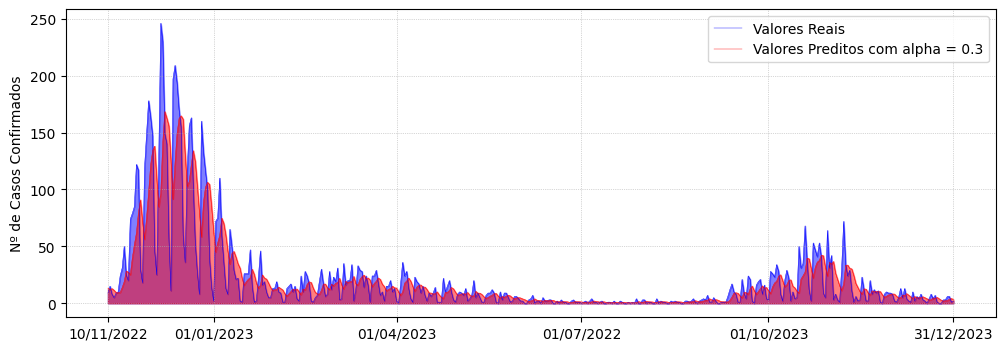

Numero de casos reais:  CasosDia    8761
dtype: int64
Numero de casos predito:  8795


In [82]:



alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 0.9]

mseSE = []
rmseSE = []
maeSE = []
parametrosSE = []
auxMae = 0

bestMse = float('inf')

treino = df[:split]
teste = df[split:]






maeCalibra = 0

## CALIBRAR
for i in alpha:
    modelo = ExponentialSmoothing(treino, initialization_method="estimated").fit(smoothing_level=i, optimized=False)
    se = (modelo.fittedvalues)
    mseCalibra = mean_squared_error(treino, se).round(2)

    if (mseCalibra < bestMse):
        bestMse = mseCalibra
        para_SE = i




## TREINA
modelo = ExponentialSmoothing(teste).fit(smoothing_level=para_SE)
se = (modelo.fittedvalues)

mae = mean_absolute_error(teste, se).round(2)
mse = mean_squared_error(teste, se).round(2)
rmse = np.sqrt(mse).round(2)



dfSuaviExpo = pd.DataFrame({
    'PARA': [para_SE],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

display(dfSuaviExpo)

stringGraf =  'graficos/4-'+ 'SuaviExpo' + '.pdf'
plt.figure(figsize=(12, 4))
plt.plot(teste, label='Valores Reais', color='blue', linewidth=0.3)
plt.plot(se, label='Valores Preditos com alpha = ' + str(para_SE), color='red', linewidth=0.3)
plt.fill_between(teste.index, teste.values.flatten(), color='blue', alpha=0.5)
plt.fill_between(teste.index, se.values.flatten(), color='red', alpha=0.5)  # Pinta a área entre as linhas
plt.ylabel('Nº de Casos Confirmados')
plt.legend()
ticks_pos = [df[split:].index[0], '2023-01','2023-04', '2023-07','2023-10', df[split:].index[-1]]
ticks_labels = [
    '10/11/2022',
    '01/01/2023',
    '01/04/2023',
    '01/07/2022',
    '01/10/2023',
    '31/12/2023',
]
plt.grid(linestyle=':', linewidth=.5, alpha=1)
plt.xticks(ticks_pos, labels=ticks_labels)
plt.savefig(stringGraf, dpi=300, bbox_inches="tight")
plt.show()

n_pred = int(se.sum())
print('Numero de casos reais: ', df[split:].sum())
print('Numero de casos predito: ', n_pred)






# ARIMA


In [74]:
parametros_grid = {
    'p': [0,1,2,3,4,5],
    'd': [0,1,2,3,4,5],
    'q': [1,2,3,4,5,6,7,8,9,10]
   }

'''
parametros_grid = {
    'p': [2],
    'd': [1],
    'q': [3]
   }
#'''

mseARIMA = []
rmseARIMA = []
maeARIMA = []

parametroP_ARIMA = []
parametroD_ARIMA = []
parametroQ_ARIMA = []
auxMae = 0


bestMse = float('inf')

dfTeste =df[split:]

j=1

## CALIBRAR
for p in parametros_grid['p']:
    print('Q')
    print(j)
    for d in parametros_grid['d']:
        #print('D')
        for q in parametros_grid['q']:
            try:
                model = ARIMA(treino['CasosDia'], order=(p,d,q))
                model_fit = model.fit()
                pred = model_fit.forecast(steps=len(treino))
                mseCalibra = mean_squared_error(treino, pred).round(2)

                if (mseCalibra < bestMse):
                    bestMse = mseCalibra
                    para_p = p
                    para_d = d
                    para_q = q
            except np.linalg.LinAlgError:
                print(f"Unable to fit model with parameters p={p}, d={d}, q={q}")
                continue
    j += 1            
    

## TREINA
model = ARIMA(teste, order=(para_p,para_d,para_q))
model_fit = model.fit()
pred = model_fit.forecast(steps=len(teste))

mae = mean_absolute_error(teste, pred).round(2)
mse = mean_squared_error(teste, pred).round(2)
rmse = np.sqrt(mse).round(2)

dfARIMA = pd.DataFrame({
    'p': [para_p],
    'd': [para_d],
    'q': [para_q],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})


print("!! ULTIMO VALOR (20) É A MÉDIA !!!")
display(dfARIMA)
dfARIMA.to_csv('resultadosModelos/dfArima.csv', sep = ';', index = False, encoding='UTF-8')





Q
1
Q
2
Unable to fit model with parameters p=1, d=5, q=5
Unable to fit model with parameters p=1, d=5, q=6
Unable to fit model with parameters p=1, d=5, q=7
Q
3
Unable to fit model with parameters p=2, d=5, q=3
Q
4
Q
5
Q
6
!! ULTIMO VALOR (20) É A MÉDIA !!!


,p,d,q,MAE,MSE,RMSE
0,5,0,1,23.19,1689.78,41.11


In [75]:
import joblib


joblib.dump(pred, 'predsSalva/arima.pkl')

['predsSalva/arima.pkl']

# CHEKPOINT

In [76]:
import joblib

pred = joblib.load('predsSalva/arima.pkl')

2022-11-10 00:00:00


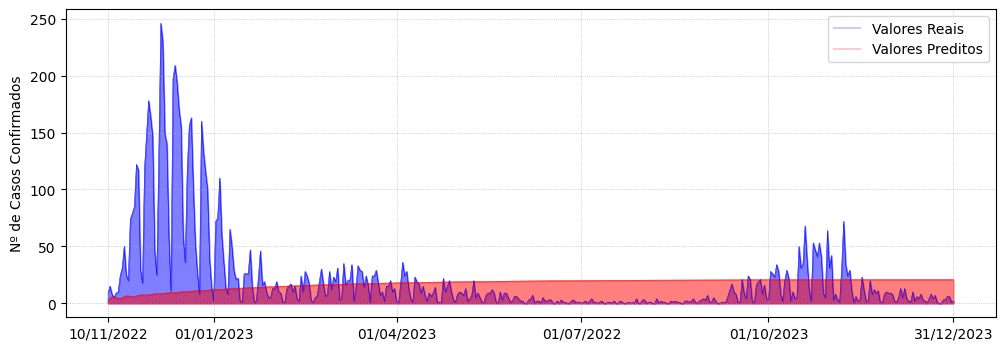

Numero de casos reais:  CasosDia    8761
dtype: int64
Numero de casos predito:  7355
Media:  17


In [81]:
stringGraf =  'graficos/4-'+ 'ARIMA' + '.pdf'
plt.figure(figsize=(12, 4))
plt.plot(df[split:], label='Valores Reais', color='blue', linewidth=0.3)
plt.plot(df.index[split:], pred, label='Valores Preditos', color='red', linewidth=0.3)
plt.fill_between(df.index[split:], df[split:].values.flatten(), color='blue', alpha=0.5)
plt.fill_between(df.index[split:], pred, color='red', alpha=0.5)  # Pinta a área entre as linhas
plt.ylabel('Nº de Casos Confirmados')
plt.legend()

print(df[split:].index[0])
ticks_pos = [df[split:].index[0], '2023-01','2023-04', '2023-07','2023-10', df[split:].index[-1]]
ticks_labels = [
    '10/11/2022',
    '01/01/2023',
    '01/04/2023',
    '01/07/2022',
    '01/10/2023',
    '31/12/2023',
]
plt.grid(linestyle=':', linewidth=.5, alpha=1)
plt.xticks(ticks_pos, labels=ticks_labels)

plt.savefig(stringGraf, dpi=300, bbox_inches="tight")
plt.show()

n_pred = int(pred.sum())
print('Numero de casos reais: ', df[split:].sum())
print('Numero de casos predito: ', n_pred)

print('Media: ', int(pred.mean()))